Cuisine Exploration Notebook 
The goal of this notebook is to look into the cuisine types listed - each restaurant has a list of cuisines associated with it. The aim is to answer these questions: 
1. what are these cuisines?
2. how can they be used as categories? - this will be helpful both for more accurate recommendations, and for better Ml results in the next step (providing a best-guess of the items on the menu based on the cuisine type)    


In [1]:
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
full_combo = pd.read_csv("full_combo.csv")
full_combo["ZipCode"].astype(int)
list_columns = ["Popular Foods", "Items", "Cuisine"]
for column in list_columns:
    full_combo[column] = full_combo[column].apply(lambda s: s.split(", ") if isinstance(s, str) else s)
full_combo.drop_duplicates(["Name", "ZipCode"], inplace=True)
full_combo

,Name,ZipCode,Rating,Price Category,Review Comment,Popular Foods,Items,Inspection Date,Inspection Grade,Inspection Critical,Cuisine,Address,grade and rating,items with no cuisine,cuisine with no items
0,218,10013,4.2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"218 Grand St, New York, 10013",False,False,False
1,251 Ginza Sushi,10016,NaN,NaN,NaN,NaN,"[soda, spring water and soda, snapple ice tea,...",NaN,NaN,NaN,"[japanese, sushi]","251 E 35th St, New York, 10016",False,False,False
2,3 Guys Restaurant,10021,NaN,NaN,“Quick lunch and good service”,NaN,"[cold cereal, cold cereal with banana, hot oat...",NaN,NaN,NaN,"[cafe, japanese, american, diner]","960 Madison Ave, New York, 10021",False,False,False
3,4 Caminos Mexican Restaurant,11385,4.1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"67-22 Fresh Pond Rd, Queens, 11385",False,False,False
4,5 Brothers Gourmet Deli,10036,NaN,NaN,NaN,NaN,"[fresh homemade beef brisket sandwich, fresh t...",NaN,NaN,NaN,"[sandwiches, deli food, american, burgers]","689 10th Ave, New York, 10036",False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,ilili Restaurant,10001,4.5,3.0,NaN,NaN,"[lunch prix fixe special, falafel wrap, grille...",NaN,NaN,NaN,"[middle eastern, mediterranean, tapas]","236 5th Ave, New York, 10001",False,False,False
800,taïm mediterranean kitchen,10038,4.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"75 Maiden Ln, New York, 10038",False,False,False
801,არგო,11223,4.6,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1985 Coney Island Ave, Brooklyn, 11223",False,False,False
802,უბანი,11209,4.7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Georgian Cuisine, 8309 3rd Ave, 11209",False,False,False


In [3]:
## for the purposes of this section, only rows with items are relevant - since the goal here is (item list -> specific cuisine)
full_combo["Valid Items"] = full_combo["Items"].apply(lambda x: isinstance(x, list))
full_combo = full_combo[full_combo["Valid Items"]]
len(full_combo)

519

#### extracting cuisine (basic) 
from restaurant name and review comment

In [4]:
cuisines = []
for line in full_combo["Cuisine"]:
    if isinstance(line, list):
        for cuisine in line:
            if cuisine not in cuisines:
                cuisines.append(cuisine.lower())
cuisines 

['japanese',
 'sushi',
 'cafe',
 'american',
 'diner',
 'sandwiches',
 'deli food',
 'burgers',
 'smoothies juices',
 'bakery pastries',
 'contemporary',
 'chinese',
 'asian',
 'latin american',
 'puerto rican',
 'pizza',
 'fast food',
 'latin',
 'indian',
 'noodles',
 'spanish',
 'mediterranean',
 'tapas',
 'teahouses',
 'soups',
 'localorganic',
 'french',
 'american new',
 'lunch specials',
 'healthy',
 'thai',
 'seafood',
 'salads',
 'greek',
 'soul food',
 'southwestern',
 'mexican',
 'italian',
 'wine bar',
 'wings',
 'chicken',
 'pasta',
 'other',
 'dominican',
 'steak',
 'bagels',
 'pretzels',
 'kosher',
 'vegetarian',
 'middle eastern',
 'lebanese',
 'moroccan',
 'cocktails',
 'bar',
 'hot dogs',
 'bistro',
 'european',
 'bar food',
 'steakhouse',
 'barbecue',
 'korean',
 'turkish',
 'alcohol',
 'brazilian',
 'south american',
 'pub',
 'gastropub',
 'argentinean',
 'nepali',
 'tibetan',
 'coffee tea',
 'vegan',
 'cajun creole',
 'german',
 'irish',
 'crepes',
 'cuban',
 'eclec

In [5]:
def find_cuisines(name):
    cuisines_in_name = []
    if isinstance(name, str):
        for word in name.lower().split():
            if word in cuisines:
                cuisines_in_name.append(word.title())
    return cuisines_in_name

In [6]:
full_combo["Cuisine"] = full_combo.apply(
    lambda row: row["Cuisine"] if isinstance(row["Cuisine"], list) else find_cuisines(row["Name"]), axis=1)
full_combo["Cuisine"] = full_combo.apply(
    lambda row: row["Cuisine"] if isinstance(row["Cuisine"], list) else find_cuisines(row["Review Comment"]), axis=1)

# note: it can be assumed that the name of a restaurant will contain the cuisine name only if it is relevant - i.e., one would expect "John's Chinese Place" (serving Chinese cuisine) but not "John's not Korean Place" (serving Chinese cuisine). In contrast, such an assumption cannot be made about a review comment - the reviewer may have been under a false impression of the cuisine that should be expected, and this could be mentioned in their review (e.g. "If this place claimed to be Elvish, these sour sauces would make sense!") - resulting in some inaccuracies. Since this dataset is a little small and isn't 100% full of the data desired, and as this is, after all, just an exercise with what is essentially dummy data, this use was left in. In production, in real-world cases, a more complex approach would be required to ensure the extraction is accurate.  

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/1425906651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Cuisine"] = full_combo.apply(
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/1425906651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Cuisine"] = full_combo.apply(


#### cleaning common naming issues 

In [7]:
## in order to clean up the cuisine names, several actions are taken here: :
# cleaning "&", removing the stopword "food", remove meaningless cuisines, merge all the cafe categories
# as well as differentiating between american cuisine and south-/latin-american cuisine by treating "american" as a stopword in those cases only. 
menu_freq = {}
def clean_cuisine(s):
    clean = s.lower().replace("&", "").strip() #replace(" food", "").
    # if "american" in clean:
    #     if clean != "american":  
    #         clean= " ".join([i for i in clean.split("american") if len(i) > 0]).strip()
    if "latin" in clean:
        clean = "latin american"
    if "american new" in clean:
        clean = "american"
    not_informaitve = ["other", "lunch specials", "mixed buffet"]
    for i in not_informaitve:
        if i == clean:
            clean = ""
    cafe_indicators = ["coffee", "tea", "cafe", "caf"]
    for i in cafe_indicators:
        if i in clean:
            clean = "cafe"
    return clean

In [8]:
full_combo["Cuisine"] = full_combo["Cuisine"].apply(lambda l: [clean_cuisine(item) for item in l if clean_cuisine(item) != ""] if isinstance(l, list) else l)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/307223599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Cuisine"] = full_combo["Cuisine"].apply(lambda l: [clean_cuisine(item) for item in l if clean_cuisine(item) != ""] if isinstance(l, list) else l)


### Question 1 - Cuisine EDA

In [9]:
full_combo["Cuisine Type Count"] = full_combo["Cuisine"].apply(lambda l: len(l) if isinstance(l, list) else 0)
full_combo["Cuisine"] = full_combo.apply(lambda row: None if row["Cuisine Type Count"] == 0 else row["Cuisine"], axis=1 )

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/1474961555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Cuisine Type Count"] = full_combo["Cuisine"].apply(lambda l: len(l) if isinstance(l, list) else 0)
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/1474961555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Cuisine"] = full_combo.apply(lambda row: None if row["Cuisine Type Count"] == 0 else row["Cuisine"], axis=1 )


In [10]:
## cuisine name frequencies 
for cuisine_list in full_combo["Cuisine"]: 
    if isinstance(cuisine_list, list):
        for cuisine in cuisine_list:
            if cuisine in menu_freq:
                menu_freq[cuisine] += 1
            else:
                menu_freq[cuisine] = 1
cuisine_freq = pd.DataFrame.from_dict(menu_freq, orient='index')
cuisine_freq.reset_index(inplace=True)
cuisine_freq.columns = ["Cuisine", "Frequency"]
cuisine_freq.sort_values(["Frequency"], ascending = False, inplace=True)
cuisine_freq.reset_index(drop=True, inplace=True)
print("Cuisine Name Frequencies")
cuisine_freq

Cuisine Name Frequencies


,Cuisine,Frequency
0,american,152
1,italian,95
2,pizza,82
3,cafe,67
4,sandwiches,66
...,...,...
98,brazilian,1
99,barbecue,1
100,lebanese,1
101,pretzels,1


<function matplotlib.pyplot.show(close=None, block=None)>

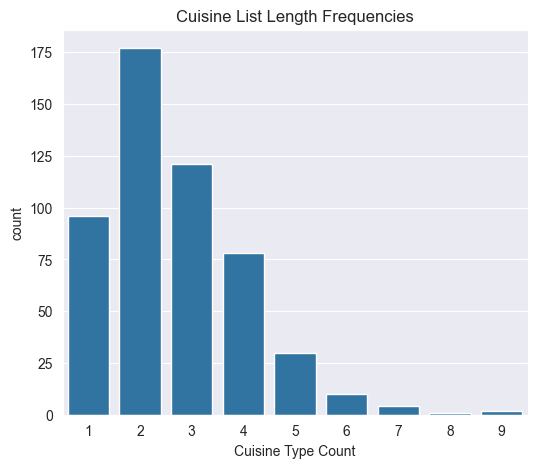

In [11]:
# cuisine list lengths 
plt.figure(figsize=(6,5))
cuisine_count = full_combo["Cuisine Type Count"].value_counts()
sns.barplot(x = cuisine_count.index, y = cuisine_count)
plt.title("Cuisine List Length Frequencies")
plt.show

## Question 2 - Finding the Cuisine Category
As the lists are an accumulation of several sources: restaurant name, Trip Advisor, Menu Data, and Inspection Data, they can be somewhat confusing to make a specific recommendation. 

For example, "3 Guys Restaurant" is described as [American, Cafe, Japanese, Diner] - while the menu items are similar to: cereal, spinach omelette, belgian waffle nutella. One of the cuisine descriptors is not appropriate - namely, "Japanese".  

The minimization will be following the assumption that the rarest cuisine is the most relevant one to the description - for example, a Mexican-Korean fusion restaurant will show up as ["Mexican", "Korean"] will be considered "Korean" if count("Mexican") > count("Korean"). Many examples from the dataset include combinations of cuisnies where this designation will be more accurate - such as ["American", "Burgers"], ["Burgers, "Sandwiches"], ["Deli Foods", "Eastern European"] - where either designation would be alright. 

The ML process here will work as follows: 
1. Create a guideline for cuisines based on single


### Training based on single-item lists

The task in this section is to create a "source of truth" of sorts, covering the cuisines that can be categorized with more certainty.  

In [12]:
inclusion_threshold = 3

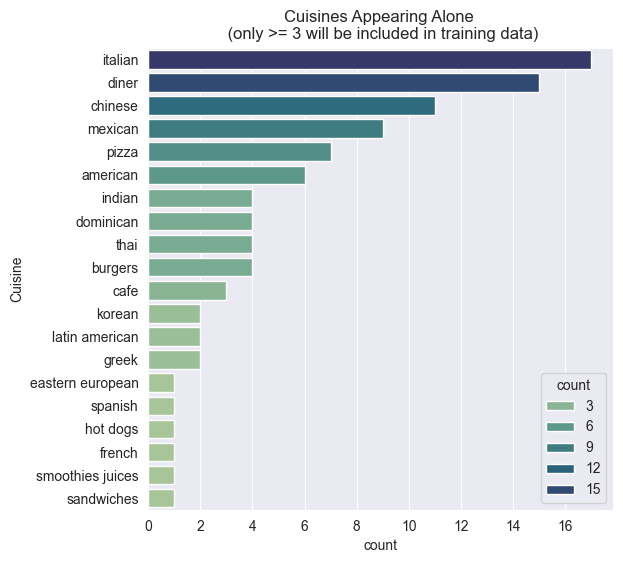

In [13]:
single_cuisine_counts = full_combo["Cuisine"][full_combo["Cuisine Type Count"] == 1].value_counts()
visual = pd.DataFrame(single_cuisine_counts)
visual.reset_index(inplace=True)
visual["Cuisine"] = visual["Cuisine"].apply(lambda l: l[0])
plt.figure(figsize=(6,6))
sns.barplot(x = visual["count"], y = visual["Cuisine"], hue = visual["count"], palette="crest")
plt.title(f"Cuisines Appearing Alone \n (only >= {inclusion_threshold} will be included in training data)")

plt.show()

In [14]:
single_cuisines = list(single_cuisine_counts[single_cuisine_counts >= inclusion_threshold].index)
# single_cuisines

In [15]:
full_combo["Single Cuisine"] = full_combo["Cuisine"].apply(lambda x: x in single_cuisines)
td_single_cuisine = full_combo[["Name", "Items", "Cuisine"]][full_combo["Single Cuisine"]]
print(f"there are {len(td_single_cuisine)} items in this data set")

there are 84 items in this data set


/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/3807290280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Single Cuisine"] = full_combo["Cuisine"].apply(lambda x: x in single_cuisines)


In [16]:
## using this data alone, how many of the menus will be covered? in other words, how many of the restaurants will have at least one label apply to them? 
def single_cuisine_coverage(cuisine_list): 
    coverage = False
    for i in single_cuisines:
        if i[0] in cuisine_list:
            coverage = True
    return coverage

In [17]:
full_combo["Training Coverage"] = full_combo["Cuisine"].apply(single_cuisine_coverage)
full_combo["Training Coverage"].value_counts(normalize=True)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/2653992643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Training Coverage"] = full_combo["Cuisine"].apply(single_cuisine_coverage)


Training Coverage
True     0.728324
False    0.271676
Name: proportion, dtype: float64

In a previous iteration, setting the threshold point at 3 examples was too low - while the coverage would have been higher (about three quarters of all the rows compared to 62% when the threshold is set at 5) - the model could not capture the similarity/difference between restaurants in cuisines with only 3 examples, and ended up returning some generic keywords.   

In [18]:
model = Word2Vec(sentences = td_single_cuisine["Items"], vector_size=500)
model.train(td_single_cuisine["Items"], total_examples=len(td_single_cuisine["Items"]), epochs=100)

(254782, 1557600)

sanity check - some cosine similarity tests

In [19]:
similarities = [("water", "soda"), ("water", "juice"), ("egg roll", "burrata")]
for item in similarities:
    print(f"the similarity of {item} is {model.wv.similarity(item[0], item[1])}")

the similarity of ('water', 'soda') is 0.9062141180038452
the similarity of ('water', 'juice') is 0.8532864451408386
the similarity of ('egg roll', 'burrata') is 0.36397308111190796


In [20]:
cuisine_terms = {}
for cuisine in list(td_single_cuisine["Cuisine"].apply(lambda l: l[0])):
    cuisine_terms[cuisine] = []
    for row in td_single_cuisine.iterrows():
        if row[1][2] == [cuisine]:
            for i in row[1][1]:
                if model.wv.has_index_for(i):
                    if i not in cuisine_terms[cuisine]:
                        cuisine_terms[cuisine].append(i)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/2787990432.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][2] == [cuisine]:
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/2787990432.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in row[1][1]:


In [21]:
most_similar_items = {}
counter = 0
for cuisine in cuisine_terms:
    cuisine_size = int(visual["count"].loc[visual["Cuisine"] == cuisine])
    for term in cuisine_terms[cuisine]:
        most_similar_items[counter] = [cuisine, cuisine_size, term, model.wv.most_similar(term)[0][0]]
        counter += 1

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_77911/3192081654.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cuisine_size = int(visual["count"].loc[visual["Cuisine"] == cuisine])


In [25]:
most_similar_items_df = pd.DataFrame.from_dict(most_similar_items, orient='index')
most_similar_items_df.columns = ["Cuisine", "Cuisine Size", "Item", "Most Similar Item"]
most_similar_items_df_5 = most_similar_items_df.loc[most_similar_items_df["Cuisine Size"] >= 5]
most_similar_items_df_3_5 = most_similar_items_df.loc[most_similar_items_df["Cuisine Size"] < 5]

In [27]:
most_similar_items_df_3_5

,Cuisine,Cuisine Size,Item,Most Similar Item
0,indian,4,canned soda,bottled water
1,indian,4,rice,avocado
2,indian,4,mixed vegetables,fried banana
3,indian,4,vegetable soup,house special soup
4,indian,4,garden salad,caesar salad with grilled chicken
...,...,...,...,...
290,burgers,4,egg salad sandwich,chicken salad sandwich
291,burgers,4,grilled chicken sandwich,chicken caesar wrap
292,burgers,4,tuna fish salad sandwich,grilled cheese sandwich
293,burgers,4,cheese fries,fresh fruit salad


In [ ]:
model.wv.most_similar("guacamole")[0][0]

In [ ]:
model.wv.most_similar("milk shake")

In [ ]:
egg_roll_similar = pd.DataFrame(model.wv.most_similar("egg roll"))
egg_roll_similar.columns = ["item", "similarity score"]
burrata_similar = pd.DataFrame(model.wv.most_similar("burrata"))
burrata_similar.columns = ["item", "similarity score"]
cheese_pizza_similar = pd.DataFrame(model.wv.most_similar("cheese pizza"))
cheese_pizza_similar.columns = ["item", "similarity score"]

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
sns.barplot(x = egg_roll_similar["similarity score"], y = egg_roll_similar["item"], palette="crest", orient="h", hue=egg_roll_similar["item"], legend=False)
plt.title("Menu Items Similar to 'egg roll'")
plt.xlim(0.5, 1.0)
plt.subplot(1, 3, 2)
sns.barplot(x = burrata_similar["similarity score"], y = burrata_similar["item"], palette="flare", orient="h", hue=burrata_similar["item"], legend=False)
plt.title("Menu Items Similar to 'burrata'")
plt.xlim(0.5, 1.0)
plt.subplot(1, 3, 3)
sns.barplot(x = cheese_pizza_similar["similarity score"], y = cheese_pizza_similar["item"], palette="cool", orient="h", hue = cheese_pizza_similar["item"], legend=False)
plt.title("Menu Items Similar to 'cheese pizza'")
plt.xlim(0.5, 1.0)
plt.subplots_adjust(wspace = 0.7)
plt.show()

In [ ]:
td_single_cuisine

In [ ]:
## these categories are noisy; some items will have next to no examples. there needs to be some fine-tuning of the categories. since there are a few hundred cuisine lists with a total of 82 individual cuisines, it seems that running idxmax on a tf-idf matrix should be the best method to determine relevance; tf-idf is sensitive to both raw item frequency and to item specifcity, so it should produce better results than the raw frequency solution.
## It should be noted that in a real-life business scenario, a combination of a computational solution and some manual review should be appropriate - making up for potential "blind spots" in the data (such as combining "Russian", "Polish" and "Eastern European" into a single category). This would be appropriate in a case when the accuracy of the categories affects the business goals - which is (fortunately) not the case for this exercise.
## fitting tf-idf with unigrams and bigrams was tested, but bigrams were deemed unhelpful for this task 
full_combo["Cuisine - String"] = full_combo["Cuisine"].apply(lambda x: " ".join([clean_cuisine(i) for i in x]) if isinstance(x, list) else x)
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
cuisine_tfidf_matrix = vectorizer.fit_transform(full_combo["Cuisine - String"])
cuisine_tfidf = pd.DataFrame(cuisine_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
cuisine_totals = cuisine_tfidf.sum(axis=0).sort_values(ascending=False)
top_15_freq = cuisine_freq.head(15)
top_15_tfidf = cuisine_totals.head(15)

plt.figure(figsize=(12, 6))
plt.suptitle("Top 15 Restaurants - ", fontsize=14, fontweight='bold')
plt.subplot(1, 2, 1)
sns.barplot(x=top_15_freq["Frequency"],  y=top_15_freq["Cuisine"], hue=top_15_freq["Cuisine"], palette='deep', legend=False)
plt.ylabel('Cuisines')
plt.title('Top 15 Cuisines - Frequency')
plt.subplot(1, 2, 2)
sns.barplot(x=top_15_tfidf.values,  y=top_15_tfidf.index, hue=top_15_tfidf.index,  legend=False, palette='deep')
plt.ylabel('Cuisines')
plt.title('Top 15 Cuisines - TF-IDF')
plt.show()
## the difference in ranking shows that TF-IDF performs better than just frequency: "sandwiches" and "american" are less prominent, while "chinese" is ranked more highly. In simple, actionable terms - the list on the right would be a preferable priority of choosing cuisines when compared to the list on the left. For example, ["diner", "sandwiches", "burgers"] will be consolidated into "burgers" if the lowest frequency is used alone; it will be consolidated as "diner" if highest TF-IDF score is used. Since there is no way to definitively say that the cuisine name chosen is the most accurate one for the specific restaurant without a human being reviewing the menu, this will do. 

In [ ]:
menu_rest_data["Cuisine - TF-IDF"] = cuisine_tfidf.idxmax(axis=1)

In [ ]:
def find_cuisine_from_cuisine_list(cuisine_list):
    if isinstance(cuisine_list, list):
        clean_list = [clean_cuisine(cuisine) for cuisine in cuisine_list]
        best_match = ""
        for cuisine in cuisine_freq["Cuisine"]:
            if cuisine in clean_list:
                best_match = cuisine
                break
        return best_match
menu_rest_data["Cuisine - Least Frequent"] = menu_rest_data["Cuisine"].apply(find_cuisine_from_cuisine_list)

In [ ]:
menu_rest_data[["Cuisine", "Cuisine - Least Frequent", "Cuisine - TF-IDF"]]